In [22]:
#! /usr/bin/env python -W ignore
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pd

# Import CSV
df = pd.read_csv('tcdimers_6_5.csv', sep=',', encoding = 'ISO-8859-1', )
df = df.drop(df.columns[[0]], axis=1)

# Drop all columns with df.new_sf < 0
print(df.shape)
df.drop(df[df.new_sf == 0].index, inplace=True)
print(df.shape)

# Generate X (=df) and y and the corresponding names
names = df.obj2
y= df.new_sf
df = df.drop(df.columns[[0, -1]], axis=1)

df.head(5)

(273, 1075)
(263, 1075)


,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,...,Unnamed: 1065,Unnamed: 1066,Unnamed: 1067,Unnamed: 1068,Unnamed: 1069,Unnamed: 1070,Unnamed: 1071,Unnamed: 1072,Unnamed: 1073,Unnamed: 1074
0,0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,1
2,0,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


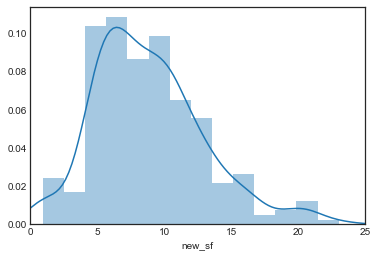

In [23]:
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_style("white")
import matplotlib.pyplot as plt

sns.distplot(y)
plt.xlim(0,25);

standard: 0.34 sec
modified: 0.46 sec
Isomap: 0.26 sec
MDS: 0.26 sec
SpectralEmbedding: 0.22 sec
t-SNE: 9.5 sec


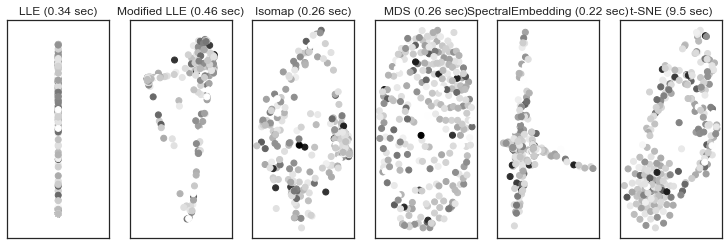

In [24]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Map y to color
miny = min(y)
maxy = max(y)
color = [(x-miny)/maxy for x in y]

# Next line to silence pyflakes. This import is needed.
Axes3D

X = df
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 4))


methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(172 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Greys)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(174)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Greys)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(175)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Greys)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(176)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Greys)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(177)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Greys)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [30]:
import warnings; warnings.simplefilter('ignore')

import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix


# Create y based on defined thresholds.
thresholds = np.linspace(2, 21, num=20)

number_below = []
number_above = []
scores = []

for threshold in thresholds:
    print('Threshold: ', threshold)
        
    # Convert y to binary (y_bin) based on threshold
    y_bin = np.where(y >= threshold, 1, 0)
    number_below.append((y_bin == 0).sum())
    number_above.append((y_bin == 1).sum())

    # For a single-input model with 2 classes (binary classification):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=df.shape[1]))
    Dropout(0.7, noise_shape=None, seed=None)
    model.add(Dense(256, activation='relu'))
    Dropout(0.7, noise_shape=None, seed=None)
    model.add(Dense(256, activation='relu'))
    Dropout(0.7, noise_shape=None, seed=None)
    model.add(Dense(32, activation='relu'))
    Dropout(0.7, noise_shape=None, seed=None)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    #This is for model evaluation via Tensorboard
    #tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, 
    #                         write_graph=True, write_images=True, write_grads = 100)

    # Train the model, iterating on the data in batches of 32 samples
    model.fit(df, y_bin, epochs=100, batch_size=32, validation_split=0.1, 
              verbose=0, callbacks=[tbCallBack])

    scores.append(model.evaluate(df, y_bin))

    y_pred = model.predict_classes(df)
    matrix = confusion_matrix(y_bin, y_pred)
    print(matrix)

2.0
263/263 [==============================] - 0s 204us/step
[[  8   2]
 [  0 253]]
3.0
263/263 [==============================] - 0s 202us/step
[[  9   2]
 [  0 252]]
4.0
263/263 [==============================] - 0s 211us/step
[[ 12   2]
 [  0 249]]
5.0
263/263 [==============================] - 0s 258us/step
[[ 28   5]
 [  0 230]]
6.0
263/263 [==============================] - 0s 1ms/step
[[ 57  15]
 [  0 191]]
7.0
263/263 [==============================] - 0s 1ms/step
[[ 82  12]
 [  2 167]]
8.0
263/263 [==============================] - 0s 1ms/step
[[110  16]
 [  4 133]]
9.0
263/263 [==============================] - 0s 1ms/step
[[129  13]
 [  6 115]]
10.0
263/263 [==============================] - 0s 1ms/step
[[155  15]
 [  4  89]]
11.0
263/263 [==============================] - 0s 888us/step
[[192   6]
 [  3  62]]
12.0
263/263 [==============================] - 0s 783us/step
[[208   1]
 [  4  50]]
13.0
263/263 [==============================] - 0s 874us/step
[[224   2]
 [  2  35]

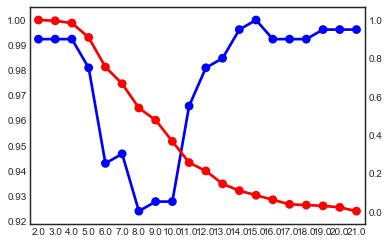

In [39]:
import seaborn as sns
sns.set_style("white")


ax = sns.pointplot(x=thresholds, y=[x[1] for x in scores], color='b');
ax2 = ax.twinx()
sns.pointplot(x=thresholds, y=[x/max(number_above) for x in number_above], color='r', ax=ax2);
#sns.pointplot(x=thresholds, y=[x[1] for x in best_score], color='g');


#ax = df.plot(x="date", y="column1", legend=False)
#ax2 = ax.twinx()
#df.plot(x="date", y="column2", ax=ax2, legend=False, color="r")
#ax.figure.legend()
plt.show()

In [43]:
from imblearn.over_sampling import RandomOverSampler 

# Convert y to binary (y_bin) based on threshold
y_bin = np.where(y >= 15, 1, 0)

cnn = RandomOverSampler(random_state=42) 
X_res, y_res = cnn.fit_sample(df, y_bin)

print(X_res.shape, y_res.shape)

(482, 1073) (482,)


In [46]:
# Convert y to binary (y_bin) based on threshold
y_bin = np.where(y >= 15, 1, 0)

# For a single-input model with 2 classes (binary classification):
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_res.shape[1]))
Dropout(0.7, noise_shape=None, seed=None)
model.add(Dense(256, activation='relu'))
Dropout(0.7, noise_shape=None, seed=None)
model.add(Dense(256, activation='relu'))
Dropout(0.7, noise_shape=None, seed=None)
model.add(Dense(32, activation='relu'))
Dropout(0.7, noise_shape=None, seed=None)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
model.fit(X_res, y_res, epochs=100, batch_size=32, validation_split=0.1, 
          verbose=0, callbacks=[tbCallBack])

model.evaluate(X_res, y_res)

y_pred = model.predict_classes(X_res)
matrix = confusion_matrix(y_res, y_pred)
print(matrix)

482/482 [==============================] - 0s 855us/step
[[241   0]
 [  0 241]]


LLE - standard: 1.9 sec
Isomap: 1.7 sec
MDS: 2.5 sec
SpectralEmbedding: 1.9 sec
t-SNE: 50 sec


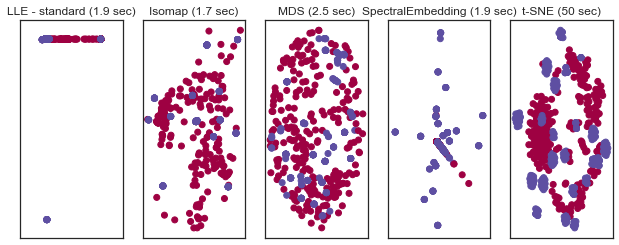

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold

# Map y_bin to color
miny = min(y_res)
maxy = max(y_res)
color = [(x-miny)/maxy for x in y_res]

X = X_res

n_neighbors = 5
n_components = 2

fig = plt.figure(figsize=(15, 4))


t0 = time()
Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                    eigen_solver='auto',
                                    method='standard').fit_transform(X)
t1 = time()
print("LLE - standard: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(172)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("LLE - standard (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')    
    
t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(173)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(174)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(175)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(176)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()